In [1]:
import cv2
import glob 
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
labels = glob.glob('DATA/train/*')

In [3]:
labels = [el[11:] for el in labels]

In [4]:
#определим имена классов
labels

['dancing charleston',
 'dancing gangnam style',
 'dancing ballet',
 'tango dancing']

In [30]:
import torch
import torchvision
from torch.utils.data import Dataset
from sklearn.metrics import accuracy_score, f1_score
torch.manual_seed(0)

In [31]:
device = torch.device("mps")

# Exp 2
## Mediapipe + LSTM

In [7]:
import mediapipe as mp

In [8]:
mpPose = mp.solutions.pose
pose = mpPose.Pose(static_image_mode=True)

I0000 00:00:1715201910.242522       1 gl_context.cc:344] GL version: 2.1 (2.1 Metal - 76.3), renderer: Apple M1


Предварительно получим точки для последующего обучения модели

In [9]:
def read_img(path):
    cap = cv2.VideoCapture(path)
    imgs_list = []
    i = 0
    while cap.isOpened():
        ret, img = cap.read()
        if ret == True:
            imgs_list.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        else: 
            break
    imgs_list = [imgs_list[el] for el in np.linspace(0, len(imgs_list)-1, 10).astype(np.int8)]
    return imgs_list

def get_results_lms(results):
    x = []
    y = []
    z = []
    if results.pose_landmarks != None:
        for lm in results.pose_landmarks.landmark:
            x.append(lm.x)
            y.append(lm.y)
            z.append(lm.z)
        lms = np.stack([x, y ,z])
        lms = lms.reshape(-1)
    else:
        lms = np.zeros(99)
    return lms
    
def prep_data(labels, train_flag=True):
    if train_flag:
        paths = glob.glob('Data/train/*/*.mp4')
    else:
        paths = glob.glob('Data/val/*/*.mp4')

    lms_list = []
    labels_list = []
    for i in tqdm(range(len(paths))):
        image = read_img(paths[i])
        for j in range(len(labels)):
            if labels[j] in paths[i]:
                label = j
        lms = []
        for img in image:
            lms.append(get_results_lms(pose.process(img)))
        lms = np.asarray(lms)
        
        lms_list.append(lms)
        labels_list.append(label)
    return np.asarray(lms_list), np.asarray(labels_list)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [10]:
lms_train, labels_train = prep_data(labels)
lms_test, labels_test = prep_data(labels, train_flag=False)

100%|█████████████████████████████████████████| 194/194 [01:15<00:00,  2.57it/s]


In [12]:
class CustomLMSDataset(Dataset):
    def __init__(self, lms, labels):
        self.lms = lms
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        lm = self.lms[idx]
        label = self.labels[idx]
        return lm, label

In [32]:
train_loader = torch.utils.data.DataLoader(
    CustomLMSDataset(lms_train, labels_train), 
    batch_size=256, shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    CustomLMSDataset(lms_test, labels_test), 
    batch_size=256, shuffle=True,
)

In [49]:
class LSTM_model(torch.nn.Module):
    def __init__(self):
        super(LSTM_model, self).__init__()
        self.lstm1 = torch.nn.LSTM(99, 128)
        self.lstm2 = torch.nn.LSTM(128, 64)
        self.dropout = torch.nn.Dropout(p = 0.4)
        self.lin1 = torch.nn.Linear(64*10, 256)
        self.lin2 = torch.nn.Linear(256, 4)
        self.softmax1 = torch.nn.Softmax(dim=1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dropout(x.view(len(x), -1))
        x = self.lin1(x)
        x = self.lin2(x)
        x = self.softmax1(x)
        return x

In [50]:
lstm_model = LSTM_model()

In [51]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.0005)

In [52]:
#Train loop
print("Start training")
loss_hist = []
val_loss_hist = []
patience = 0
lstm_model.to(device)

for epoch in range(150):
    lstm_model.train(True)
    running_loss = 0.0
    iters = 0
    train_acc = 0
    train_f1 = 0
    print('_____________________')
    print('EPOCH: ', epoch+1)
    for i, (lms, label) in enumerate(tqdm(train_loader)):
        optimizer.zero_grad()

        res = lstm_model(lms.float().to(device))
        loss = criterion(res, label.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        iters += 1
        train_acc += accuracy_score(label, res.cpu().argmax(dim=1))
        train_f1 += f1_score(label, res.cpu().argmax(dim=1), average='weighted')
    loss_hist.append(running_loss/iters)
    train_acc = train_acc/iters
    train_f1 = train_f1/iters
    
    #show results per epoch
    print('train_loss = ', running_loss/iters)
    print(f'Train: accuracy = {train_acc}, F1 = {train_f1}')

    #validating
    running_loss = 0.0
    iters = 0
    test_acc = 0
    test_f1 = 0
    lstm_model.eval()
    with torch.no_grad():
        for i ,(test_lms, test_label) in enumerate(test_loader, 0):
            val_res = lstm_model(test_lms.float().to(device))
            val_loss = criterion(val_res, test_label.to(device))
            running_loss += val_loss.item()
            iters += 1
            test_acc += accuracy_score(test_label, val_res.cpu().argmax(dim=1))
            test_f1 += f1_score(test_label, val_res.cpu().argmax(dim=1), average='weighted')
        val_loss_hist.append(running_loss/iters)
        test_acc = test_acc/iters
        test_f1 = test_f1/iters
        
    #show val results per epoch   
    print('val_loss = ', running_loss/iters)
    print(f'Test: accuracy = {test_acc}, F1 = {test_f1}')
    print('\n')

    #early stop
    if epoch > 3:
        if val_loss_hist[-1] > val_loss_hist[-2]:
            patience += 1
        else:
            patience = 0
    if patience == 8:
        break

    #save best model
    if epoch == 0:
        best_f1 = test_f1
    else:
        if test_f1 > best_f1:
            best_f1 = test_f1
            torch.save(lstm_model, 'models/lstm_model_best.pth')
print('Finish! Num epochs: ', epoch+1)

Start training
_____________________
EPOCH:  1


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 13.27it/s]


train_loss =  1.386348565419515
Train: accuracy = 0.251135587431694, F1 = 0.10684840162400576
val_loss =  1.3842321634292603
Test: accuracy = 0.27319587628865977, F1 = 0.15676986871650303


_____________________
EPOCH:  2


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 13.84it/s]


train_loss =  1.3785974661509195
Train: accuracy = 0.2881119080145719, F1 = 0.19056586215649382
val_loss =  1.3697797060012817
Test: accuracy = 0.28350515463917525, F1 = 0.17922301982408884


_____________________
EPOCH:  3


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 13.84it/s]


train_loss =  1.3432172536849976
Train: accuracy = 0.3438866120218579, F1 = 0.23166350614838868
val_loss =  1.3374061584472656
Test: accuracy = 0.32989690721649484, F1 = 0.22019160678954497


_____________________
EPOCH:  4


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.3101783037185668
Train: accuracy = 0.3772185223132969, F1 = 0.2860528496565912
val_loss =  1.305474042892456
Test: accuracy = 0.3711340206185567, F1 = 0.2915384327746414


_____________________
EPOCH:  5


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.301603945096334
Train: accuracy = 0.3970116120218579, F1 = 0.35269348293187563
val_loss =  1.3073498010635376
Test: accuracy = 0.3711340206185567, F1 = 0.3131591018643778


_____________________
EPOCH:  6


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.2964257717132568
Train: accuracy = 0.40076132741347903, F1 = 0.3780099197448176
val_loss =  1.2956130504608154
Test: accuracy = 0.44329896907216493, F1 = 0.44819377685542505


_____________________
EPOCH:  7


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2944124221801758
Train: accuracy = 0.4037269467213115, F1 = 0.3802426478066946
val_loss =  1.298969030380249
Test: accuracy = 0.4020618556701031, F1 = 0.37405993909837


_____________________
EPOCH:  8


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.44it/s]


train_loss =  1.292873167991638
Train: accuracy = 0.3993510928961748, F1 = 0.3861970791537992
val_loss =  1.2912027835845947
Test: accuracy = 0.4381443298969072, F1 = 0.4355693283110268


_____________________
EPOCH:  9


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.44it/s]


train_loss =  1.2879480123519897
Train: accuracy = 0.4128927595628415, F1 = 0.39619520409058634
val_loss =  1.286903977394104
Test: accuracy = 0.41237113402061853, F1 = 0.397827427116564


_____________________
EPOCH:  10


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.2843441804250082
Train: accuracy = 0.42273878642987245, F1 = 0.3987110365190858
val_loss =  1.296269178390503
Test: accuracy = 0.42783505154639173, F1 = 0.3919808506671787


_____________________
EPOCH:  11


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2877519925435383
Train: accuracy = 0.4133637864298725, F1 = 0.39833979963082417
val_loss =  1.2920069694519043
Test: accuracy = 0.422680412371134, F1 = 0.41213106724678117


_____________________
EPOCH:  12


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2781192143758138
Train: accuracy = 0.43565573770491806, F1 = 0.42423622254840254
val_loss =  1.268178939819336
Test: accuracy = 0.4536082474226804, F1 = 0.4533077154200117


_____________________
EPOCH:  13


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.2745820999145507
Train: accuracy = 0.440338968579235, F1 = 0.4349164103546551
val_loss =  1.262740969657898
Test: accuracy = 0.4639175257731959, F1 = 0.46257283729269394


_____________________
EPOCH:  14


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.38it/s]


train_loss =  1.27058740456899
Train: accuracy = 0.4462758993624772, F1 = 0.44106520702899465
val_loss =  1.2536033391952515
Test: accuracy = 0.4793814432989691, F1 = 0.4736274848320427


_____________________
EPOCH:  15


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.2641191005706787
Train: accuracy = 0.4563809198542805, F1 = 0.452209510850088
val_loss =  1.2503410577774048
Test: accuracy = 0.4690721649484536, F1 = 0.4595082349608513


_____________________
EPOCH:  16


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.38it/s]


train_loss =  1.263494650522868
Train: accuracy = 0.45081113387978144, F1 = 0.43525944175818093
val_loss =  1.2333941459655762
Test: accuracy = 0.4845360824742268, F1 = 0.47571135415560106


_____________________
EPOCH:  17


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.28it/s]


train_loss =  1.252813164393107
Train: accuracy = 0.46351747495446266, F1 = 0.4578684668853177
val_loss =  1.2257133722305298
Test: accuracy = 0.520618556701031, F1 = 0.5194261902945684


_____________________
EPOCH:  18


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.2473286390304565
Train: accuracy = 0.471588968579235, F1 = 0.46811228815846323
val_loss =  1.2231249809265137
Test: accuracy = 0.4948453608247423, F1 = 0.4925098630907241


_____________________
EPOCH:  19


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.2539567550023396
Train: accuracy = 0.460655737704918, F1 = 0.4502986463478178
val_loss =  1.2209746837615967
Test: accuracy = 0.5103092783505154, F1 = 0.5058851801119842


_____________________
EPOCH:  20


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.27it/s]


train_loss =  1.2443174282709757
Train: accuracy = 0.47768385701275046, F1 = 0.46835928203776067
val_loss =  1.2199612855911255
Test: accuracy = 0.5103092783505154, F1 = 0.5038919164756445


_____________________
EPOCH:  21


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2413419802983603
Train: accuracy = 0.47992657103825137, F1 = 0.47137394695789675
val_loss =  1.2149600982666016
Test: accuracy = 0.4948453608247423, F1 = 0.49321571489325533


_____________________
EPOCH:  22


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.2391188621520997
Train: accuracy = 0.48273565573770494, F1 = 0.4722220447433513
val_loss =  1.2236731052398682
Test: accuracy = 0.520618556701031, F1 = 0.5168147884820475


_____________________
EPOCH:  23


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.238902227083842
Train: accuracy = 0.4865906762295082, F1 = 0.47819859656384317
val_loss =  1.2230526208877563
Test: accuracy = 0.5257731958762887, F1 = 0.5203830219557716


_____________________
EPOCH:  24


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.2350776672363282
Train: accuracy = 0.48768072632058285, F1 = 0.47873752763056826
val_loss =  1.227294683456421
Test: accuracy = 0.4896907216494845, F1 = 0.48753638583748904


_____________________
EPOCH:  25


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.45it/s]


train_loss =  1.229068915049235
Train: accuracy = 0.49513177367941713, F1 = 0.48865170380709044
val_loss =  1.2134745121002197
Test: accuracy = 0.5257731958762887, F1 = 0.5261156870938157


_____________________
EPOCH:  26


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.227011760075887
Train: accuracy = 0.4971596083788707, F1 = 0.4888228089851175
val_loss =  1.2159922122955322
Test: accuracy = 0.4793814432989691, F1 = 0.4760716671282778


_____________________
EPOCH:  27


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.2253677209218343
Train: accuracy = 0.500286031420765, F1 = 0.49367654716500553
val_loss =  1.2156537771224976
Test: accuracy = 0.5051546391752577, F1 = 0.5054087457807808


_____________________
EPOCH:  28


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2306196769078572
Train: accuracy = 0.4928378301457195, F1 = 0.4785145617039755
val_loss =  1.2209938764572144
Test: accuracy = 0.5, F1 = 0.5000445910252852


_____________________
EPOCH:  29


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.226509928703308
Train: accuracy = 0.4961222108378871, F1 = 0.48808242053620343
val_loss =  1.2218941450119019
Test: accuracy = 0.4845360824742268, F1 = 0.4867157011508677


_____________________
EPOCH:  30


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.219029418627421
Train: accuracy = 0.5060123520036429, F1 = 0.497918579463955
val_loss =  1.2105573415756226
Test: accuracy = 0.520618556701031, F1 = 0.5221967606937269


_____________________
EPOCH:  31


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.2240424553553264
Train: accuracy = 0.5007599043715847, F1 = 0.4943025080861394
val_loss =  1.197027325630188
Test: accuracy = 0.5309278350515464, F1 = 0.5266406558057075


_____________________
EPOCH:  32


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.2176104307174682
Train: accuracy = 0.5098161429872495, F1 = 0.5070017732116904
val_loss =  1.1942520141601562
Test: accuracy = 0.5463917525773195, F1 = 0.5430883236010425


_____________________
EPOCH:  33


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.16it/s]


train_loss =  1.2168750603993734
Train: accuracy = 0.5049749544626594, F1 = 0.49947166331411014
val_loss =  1.2069212198257446
Test: accuracy = 0.520618556701031, F1 = 0.5208301957073765


_____________________
EPOCH:  34


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.21it/s]


train_loss =  1.2162567933400472
Train: accuracy = 0.5097649134790528, F1 = 0.5044139293846265
val_loss =  1.206465721130371
Test: accuracy = 0.5103092783505154, F1 = 0.4999674580860148


_____________________
EPOCH:  35


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.25it/s]


train_loss =  1.2121308326721192
Train: accuracy = 0.5197162454462659, F1 = 0.5146185483631768
val_loss =  1.2075482606887817
Test: accuracy = 0.5257731958762887, F1 = 0.5289336061949239


_____________________
EPOCH:  36


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.48it/s]


train_loss =  1.2110314130783082
Train: accuracy = 0.5172131147540984, F1 = 0.5118737376469968
val_loss =  1.1999117136001587
Test: accuracy = 0.5257731958762887, F1 = 0.5257404680085093


_____________________
EPOCH:  37


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.40it/s]


train_loss =  1.2046462059020997
Train: accuracy = 0.5238800660291438, F1 = 0.5235212204683778
val_loss =  1.1969091892242432
Test: accuracy = 0.5154639175257731, F1 = 0.5124324479694161


_____________________
EPOCH:  38


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2032872835795085
Train: accuracy = 0.5270562955373407, F1 = 0.5236290965295152
val_loss =  1.2154005765914917
Test: accuracy = 0.5051546391752577, F1 = 0.4974809946190695


_____________________
EPOCH:  39


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.2086722215016683
Train: accuracy = 0.517682718579235, F1 = 0.510362600737571
val_loss =  1.2117351293563843
Test: accuracy = 0.5051546391752577, F1 = 0.4986848327957516


_____________________
EPOCH:  40


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


train_loss =  1.2029911279678345
Train: accuracy = 0.5265326161202186, F1 = 0.5248762381256799
val_loss =  1.2118662595748901
Test: accuracy = 0.4948453608247423, F1 = 0.4953427627831347


_____________________
EPOCH:  41


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.25it/s]


train_loss =  1.2049082199732462
Train: accuracy = 0.5195042122040073, F1 = 0.5152467738548062
val_loss =  1.2113243341445923
Test: accuracy = 0.520618556701031, F1 = 0.5207813485499133


_____________________
EPOCH:  42


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.30it/s]


train_loss =  1.1993513425191245
Train: accuracy = 0.5289830942622951, F1 = 0.529098439520835
val_loss =  1.1984161138534546
Test: accuracy = 0.5051546391752577, F1 = 0.5022539828063292


_____________________
EPOCH:  43


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1957869052886962
Train: accuracy = 0.5317950250455373, F1 = 0.528108233451063
val_loss =  1.206831455230713
Test: accuracy = 0.5360824742268041, F1 = 0.537596683576065


_____________________
EPOCH:  44


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.1951510190963746
Train: accuracy = 0.5323158583788706, F1 = 0.5309147557204843
val_loss =  1.2013933658599854
Test: accuracy = 0.5360824742268041, F1 = 0.5295940679331846


_____________________
EPOCH:  45


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.30it/s]


train_loss =  1.1870395183563232
Train: accuracy = 0.5431480532786885, F1 = 0.5415149291064911
val_loss =  1.2090593576431274
Test: accuracy = 0.520618556701031, F1 = 0.5203633943107808


_____________________
EPOCH:  46


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.189742620786031
Train: accuracy = 0.5385146288706739, F1 = 0.5382705247250105
val_loss =  1.1974091529846191
Test: accuracy = 0.5515463917525774, F1 = 0.5458694981437489


_____________________
EPOCH:  47


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.22it/s]


train_loss =  1.186561894416809
Train: accuracy = 0.5457038365209471, F1 = 0.5434959432417081
val_loss =  1.1990731954574585
Test: accuracy = 0.5154639175257731, F1 = 0.5055602302788893


_____________________
EPOCH:  48


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.1852132161458333
Train: accuracy = 0.5424208788706739, F1 = 0.5401632370568764
val_loss =  1.2015036344528198
Test: accuracy = 0.520618556701031, F1 = 0.5195894547746625


_____________________
EPOCH:  49


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1818726142247518
Train: accuracy = 0.5478882058287796, F1 = 0.5469043231977323
val_loss =  1.1924701929092407
Test: accuracy = 0.5412371134020618, F1 = 0.5415662178513856


_____________________
EPOCH:  50


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.22it/s]


train_loss =  1.1786343892415365
Train: accuracy = 0.5561190801457195, F1 = 0.5548731536442433
val_loss =  1.1925060749053955
Test: accuracy = 0.5618556701030928, F1 = 0.5666512474589872


_____________________
EPOCH:  51


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.40it/s]


train_loss =  1.178833285967509
Train: accuracy = 0.552106102003643, F1 = 0.552638933977062
val_loss =  1.2045857906341553
Test: accuracy = 0.5257731958762887, F1 = 0.5233467837273497


_____________________
EPOCH:  52


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.45it/s]


train_loss =  1.1812799135843912
Train: accuracy = 0.5492400956284152, F1 = 0.547568687217876
val_loss =  1.1934783458709717
Test: accuracy = 0.5567010309278351, F1 = 0.5548972408342675


_____________________
EPOCH:  53


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.1823698918024699
Train: accuracy = 0.5491362135701275, F1 = 0.5433024540284279
val_loss =  1.2023992538452148
Test: accuracy = 0.5412371134020618, F1 = 0.5273274161040706


_____________________
EPOCH:  54


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.1797877391179403
Train: accuracy = 0.5513291211293261, F1 = 0.5482392270162647
val_loss =  1.1892902851104736
Test: accuracy = 0.5309278350515464, F1 = 0.5174549037050775


_____________________
EPOCH:  55


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1738918701807657
Train: accuracy = 0.555959699453552, F1 = 0.5546639539796845
val_loss =  1.2004486322402954
Test: accuracy = 0.5360824742268041, F1 = 0.5252313579889355


_____________________
EPOCH:  56


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.44it/s]


train_loss =  1.1678766091664632
Train: accuracy = 0.5657544968123862, F1 = 0.5621400301241948
val_loss =  1.1954915523529053
Test: accuracy = 0.5309278350515464, F1 = 0.5233690090485555


_____________________
EPOCH:  57


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.176434318224589
Train: accuracy = 0.560281477686703, F1 = 0.5594954161727258
val_loss =  1.2023561000823975
Test: accuracy = 0.5154639175257731, F1 = 0.5050324748589773


_____________________
EPOCH:  58


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.54it/s]


train_loss =  1.1850234111150106
Train: accuracy = 0.5425233378870674, F1 = 0.5388039152059682
val_loss =  1.2052128314971924
Test: accuracy = 0.5154639175257731, F1 = 0.5184066591528409


_____________________
EPOCH:  59


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.1814501523971557
Train: accuracy = 0.5542918943533697, F1 = 0.5488666453799016
val_loss =  1.1808276176452637
Test: accuracy = 0.5618556701030928, F1 = 0.5563042447019994


_____________________
EPOCH:  60


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.1783111413319907
Train: accuracy = 0.554192281420765, F1 = 0.5490784567027113
val_loss =  1.2002507448196411
Test: accuracy = 0.5154639175257731, F1 = 0.5098960898444291


_____________________
EPOCH:  61


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.1702486276626587
Train: accuracy = 0.5564833788706739, F1 = 0.5529463884889623
val_loss =  1.1930344104766846
Test: accuracy = 0.5154639175257731, F1 = 0.5184039834919434


_____________________
EPOCH:  62


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.42it/s]


train_loss =  1.1630202531814575
Train: accuracy = 0.572257798269581, F1 = 0.5716698293014083
val_loss =  1.183883547782898
Test: accuracy = 0.5463917525773195, F1 = 0.5432030233053665


_____________________
EPOCH:  63


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1702366511027018
Train: accuracy = 0.5651269353369763, F1 = 0.5639016478772272
val_loss =  1.1891108751296997
Test: accuracy = 0.5567010309278351, F1 = 0.5577182063653139


_____________________
EPOCH:  64


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.28it/s]


train_loss =  1.1659911394119262
Train: accuracy = 0.5619464367030965, F1 = 0.5597080413197691
val_loss =  1.1852586269378662
Test: accuracy = 0.5463917525773195, F1 = 0.5449753665997065


_____________________
EPOCH:  65


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.40it/s]


train_loss =  1.1618906259536743
Train: accuracy = 0.5708034494535519, F1 = 0.5704350776408468
val_loss =  1.1835224628448486
Test: accuracy = 0.5618556701030928, F1 = 0.5595754476222261


_____________________
EPOCH:  66


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


train_loss =  1.160995594660441
Train: accuracy = 0.5729380122950819, F1 = 0.5709229653012611
val_loss =  1.1853609085083008
Test: accuracy = 0.5463917525773195, F1 = 0.541919744399616


_____________________
EPOCH:  67


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.160621953010559
Train: accuracy = 0.5724741006375228, F1 = 0.5709730476662828
val_loss =  1.1894094944000244
Test: accuracy = 0.5360824742268041, F1 = 0.5354925504952635


_____________________
EPOCH:  68


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.1640674829483033
Train: accuracy = 0.5715320469034608, F1 = 0.5710880625692079
val_loss =  1.1737022399902344
Test: accuracy = 0.5670103092783505, F1 = 0.563112137170858


_____________________
EPOCH:  69


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.1614303270975748
Train: accuracy = 0.5691897199453552, F1 = 0.5690565801412417
val_loss =  1.1819732189178467
Test: accuracy = 0.5463917525773195, F1 = 0.5376497837886913


_____________________
EPOCH:  70


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.43it/s]


train_loss =  1.1598477125167848
Train: accuracy = 0.5712716302367942, F1 = 0.5700592844403278
val_loss =  1.1797391176223755
Test: accuracy = 0.5463917525773195, F1 = 0.5473144920862152


_____________________
EPOCH:  71


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.1547104597091675
Train: accuracy = 0.5771018328779599, F1 = 0.5773797230889506
val_loss =  1.1646069288253784
Test: accuracy = 0.5463917525773195, F1 = 0.5428554750260951


_____________________
EPOCH:  72


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1535585403442383
Train: accuracy = 0.5793957764116576, F1 = 0.5786504579708505
val_loss =  1.167488932609558
Test: accuracy = 0.5618556701030928, F1 = 0.5571702297097427


_____________________
EPOCH:  73


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.160740327835083
Train: accuracy = 0.5726761725865209, F1 = 0.5726489656618197
val_loss =  1.1797206401824951
Test: accuracy = 0.5670103092783505, F1 = 0.5674566258595547


_____________________
EPOCH:  74


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.45it/s]


train_loss =  1.1575830141703287
Train: accuracy = 0.5815872609289617, F1 = 0.581525042945212
val_loss =  1.1695643663406372
Test: accuracy = 0.5567010309278351, F1 = 0.5595061389740915


_____________________
EPOCH:  75


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.1546406507492066
Train: accuracy = 0.5790827071948998, F1 = 0.5777648610019093
val_loss =  1.1798092126846313
Test: accuracy = 0.5721649484536082, F1 = 0.5733556149712399


_____________________
EPOCH:  76


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.25it/s]


train_loss =  1.1571977615356446
Train: accuracy = 0.5795523110200363, F1 = 0.5807308854600379
val_loss =  1.1796081066131592
Test: accuracy = 0.5515463917525774, F1 = 0.539234015196229


_____________________
EPOCH:  77


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.51it/s]


train_loss =  1.1587393760681153
Train: accuracy = 0.5767944558287795, F1 = 0.5768911666573789
val_loss =  1.1760036945343018
Test: accuracy = 0.5309278350515464, F1 = 0.5351554242044004


_____________________
EPOCH:  78


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.1549458821614584
Train: accuracy = 0.5750227686703097, F1 = 0.5723131800819026
val_loss =  1.1884467601776123
Test: accuracy = 0.5309278350515464, F1 = 0.5217920432616093


_____________________
EPOCH:  79


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.153437582651774
Train: accuracy = 0.5820540186703096, F1 = 0.5814861238377327
val_loss =  1.1873606443405151
Test: accuracy = 0.5412371134020618, F1 = 0.5408530912353731


_____________________
EPOCH:  80


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.150926367441813
Train: accuracy = 0.5811674635701275, F1 = 0.576588606950147
val_loss =  1.1758382320404053
Test: accuracy = 0.5360824742268041, F1 = 0.5387097453740499


_____________________
EPOCH:  81


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.1466031471888225
Train: accuracy = 0.5880934084699453, F1 = 0.5876136277854656
val_loss =  1.1804345846176147
Test: accuracy = 0.5360824742268041, F1 = 0.5345941603110455


_____________________
EPOCH:  82


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.45it/s]


train_loss =  1.1560765345891317
Train: accuracy = 0.5760132058287796, F1 = 0.5720591674008096
val_loss =  1.19209623336792
Test: accuracy = 0.5257731958762887, F1 = 0.5263607446394535


_____________________
EPOCH:  83


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.1544266223907471
Train: accuracy = 0.5790855532786885, F1 = 0.57681397456644
val_loss =  1.1947940587997437
Test: accuracy = 0.5463917525773195, F1 = 0.5459970569434256


_____________________
EPOCH:  84


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1514318625132243
Train: accuracy = 0.5849712545537341, F1 = 0.5826634810189975
val_loss =  1.1900626420974731
Test: accuracy = 0.5154639175257731, F1 = 0.5149324706936079


_____________________
EPOCH:  85


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.1518992106119792
Train: accuracy = 0.585281477686703, F1 = 0.5829899539409008
val_loss =  1.1793537139892578
Test: accuracy = 0.5463917525773195, F1 = 0.5480068278138835


_____________________
EPOCH:  86


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1606502453486125
Train: accuracy = 0.5722634904371585, F1 = 0.5713204736571265
val_loss =  1.175466537475586
Test: accuracy = 0.5309278350515464, F1 = 0.5249468244969652


_____________________
EPOCH:  87


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.1481597820917766
Train: accuracy = 0.5859090391621129, F1 = 0.5854691458922984
val_loss =  1.183104395866394
Test: accuracy = 0.520618556701031, F1 = 0.5230156900439931


_____________________
EPOCH:  88


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.1466241121292113
Train: accuracy = 0.590121243169399, F1 = 0.5884330203412381
val_loss =  1.1655843257904053
Test: accuracy = 0.5567010309278351, F1 = 0.5547675252114893


_____________________
EPOCH:  89


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1406150341033936
Train: accuracy = 0.5956440687613843, F1 = 0.5962267580462005
val_loss =  1.1650466918945312
Test: accuracy = 0.5463917525773195, F1 = 0.5440401113276975


_____________________
EPOCH:  90


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


train_loss =  1.1445733070373536
Train: accuracy = 0.5943462545537341, F1 = 0.5937882689626635
val_loss =  1.17412269115448
Test: accuracy = 0.5515463917525774, F1 = 0.54537027695538


_____________________
EPOCH:  91


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1424924294153849
Train: accuracy = 0.5929915186703096, F1 = 0.5912353891144048
val_loss =  1.1703968048095703
Test: accuracy = 0.5773195876288659, F1 = 0.5741160529406555


_____________________
EPOCH:  92


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.28it/s]


train_loss =  1.1507159392038981
Train: accuracy = 0.5873135815118397, F1 = 0.5862770941160519
val_loss =  1.1580400466918945
Test: accuracy = 0.5721649484536082, F1 = 0.56544105971612


_____________________
EPOCH:  93


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.1413799206415811
Train: accuracy = 0.594603825136612, F1 = 0.5931627013921853
val_loss =  1.1568273305892944
Test: accuracy = 0.5721649484536082, F1 = 0.5643546967311632


_____________________
EPOCH:  94


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.47it/s]


train_loss =  1.1430216630299885
Train: accuracy = 0.5939805327868852, F1 = 0.5951228042089671
val_loss =  1.1711660623550415
Test: accuracy = 0.5721649484536082, F1 = 0.5679814085531476


_____________________
EPOCH:  95


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.38it/s]


train_loss =  1.1445881128311157
Train: accuracy = 0.5935635815118396, F1 = 0.5941149195477505
val_loss =  1.1659619808197021
Test: accuracy = 0.5670103092783505, F1 = 0.5540713721044958


_____________________
EPOCH:  96


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.29it/s]


train_loss =  1.1394206364949544
Train: accuracy = 0.5965348929872495, F1 = 0.5963778494323088
val_loss =  1.1607040166854858
Test: accuracy = 0.5773195876288659, F1 = 0.5698654860096033


_____________________
EPOCH:  97


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.30it/s]


train_loss =  1.1444167375564576
Train: accuracy = 0.5864782559198543, F1 = 0.5849836890351964
val_loss =  1.1662613153457642
Test: accuracy = 0.5618556701030928, F1 = 0.5535869603766211


_____________________
EPOCH:  98


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.1541380008061728
Train: accuracy = 0.576115664845173, F1 = 0.5739227166813705
val_loss =  1.1716978549957275
Test: accuracy = 0.5721649484536082, F1 = 0.5665986540664375


_____________________
EPOCH:  99


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.25it/s]


train_loss =  1.15168186823527
Train: accuracy = 0.5834059084699453, F1 = 0.5820595250308459
val_loss =  1.1623847484588623
Test: accuracy = 0.5773195876288659, F1 = 0.5736206475574118


_____________________
EPOCH:  100


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


train_loss =  1.1382149775822958
Train: accuracy = 0.5972079918032787, F1 = 0.5973422063217311
val_loss =  1.1619477272033691
Test: accuracy = 0.5567010309278351, F1 = 0.5546865307034647


_____________________
EPOCH:  101


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.42it/s]


train_loss =  1.1370997428894043
Train: accuracy = 0.604449852003643, F1 = 0.6047752817590972
val_loss =  1.1699516773223877
Test: accuracy = 0.5567010309278351, F1 = 0.553661023412092


_____________________
EPOCH:  102


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.1324870189030964
Train: accuracy = 0.6052325250455373, F1 = 0.6061252579864387
val_loss =  1.1550341844558716
Test: accuracy = 0.5824742268041238, F1 = 0.5812430527077618


_____________________
EPOCH:  103


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.138498640060425
Train: accuracy = 0.5940829918032786, F1 = 0.5934555297694051
val_loss =  1.1602221727371216
Test: accuracy = 0.5927835051546392, F1 = 0.5793633568457226


_____________________
EPOCH:  104


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.137097676595052
Train: accuracy = 0.5983549635701275, F1 = 0.5970124139687633
val_loss =  1.1679823398590088
Test: accuracy = 0.5567010309278351, F1 = 0.5455456507499732


_____________________
EPOCH:  105


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.1332136392593384
Train: accuracy = 0.6066868738615665, F1 = 0.6073506020636436
val_loss =  1.1670299768447876
Test: accuracy = 0.5773195876288659, F1 = 0.5671648163752492


_____________________
EPOCH:  106


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


train_loss =  1.1331173658370972
Train: accuracy = 0.6037682149362477, F1 = 0.6041190737783974
val_loss =  1.1677727699279785
Test: accuracy = 0.5773195876288659, F1 = 0.5699851901032407


_____________________
EPOCH:  107


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.129795002937317
Train: accuracy = 0.6077811930783242, F1 = 0.6073327039002648
val_loss =  1.1643462181091309
Test: accuracy = 0.5927835051546392, F1 = 0.5914990928276572


_____________________
EPOCH:  108


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.40it/s]


train_loss =  1.133071001370748
Train: accuracy = 0.605021914845173, F1 = 0.6059511849768019
val_loss =  1.1596183776855469
Test: accuracy = 0.5824742268041238, F1 = 0.5771859450269239


_____________________
EPOCH:  109


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.1245404481887817
Train: accuracy = 0.6128842213114754, F1 = 0.6128291249615881
val_loss =  1.1630765199661255
Test: accuracy = 0.5824742268041238, F1 = 0.5708443119899721


_____________________
EPOCH:  110


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.33it/s]


train_loss =  1.1301507949829102
Train: accuracy = 0.6073599726775957, F1 = 0.6073424469502974
val_loss =  1.156545639038086
Test: accuracy = 0.5773195876288659, F1 = 0.5721814518913364


_____________________
EPOCH:  111


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.44it/s]


train_loss =  1.1305578231811524
Train: accuracy = 0.6064791097449909, F1 = 0.6040894337684374
val_loss =  1.1837154626846313
Test: accuracy = 0.5360824742268041, F1 = 0.5384073560765916


_____________________
EPOCH:  112


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.1251314957936605
Train: accuracy = 0.61303933287796, F1 = 0.6131942331806347
val_loss =  1.150830864906311
Test: accuracy = 0.5927835051546392, F1 = 0.5915355504694698


_____________________
EPOCH:  113


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.1346731980641682
Train: accuracy = 0.5985114981785064, F1 = 0.5984104774955173
val_loss =  1.162851333618164
Test: accuracy = 0.5515463917525774, F1 = 0.550176725857989


_____________________
EPOCH:  114


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.36it/s]


train_loss =  1.1274349133173625
Train: accuracy = 0.6091828893442623, F1 = 0.6100365019073094
val_loss =  1.1690771579742432
Test: accuracy = 0.5773195876288659, F1 = 0.5699662201282866


_____________________
EPOCH:  115


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.1272764046986898
Train: accuracy = 0.6069970969945355, F1 = 0.6070856594365764
val_loss =  1.153937578201294
Test: accuracy = 0.5824742268041238, F1 = 0.5786566794625906


_____________________
EPOCH:  116


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.26it/s]


train_loss =  1.12689528465271
Train: accuracy = 0.6125739981785063, F1 = 0.6132776647783229
val_loss =  1.1603267192840576
Test: accuracy = 0.5618556701030928, F1 = 0.556829525544947


_____________________
EPOCH:  117


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1294119040171304
Train: accuracy = 0.6092398110200363, F1 = 0.6093862524128985
val_loss =  1.156341314315796
Test: accuracy = 0.5876288659793815, F1 = 0.5769959449351942


_____________________
EPOCH:  118


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.23it/s]


train_loss =  1.1354591925938924
Train: accuracy = 0.6007527891621129, F1 = 0.6000949865228297
val_loss =  1.1663751602172852
Test: accuracy = 0.5567010309278351, F1 = 0.543382453682718


_____________________
EPOCH:  119


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1276846965154013
Train: accuracy = 0.610281477686703, F1 = 0.6108025113763353
val_loss =  1.158623218536377
Test: accuracy = 0.5824742268041238, F1 = 0.5754112271395473


_____________________
EPOCH:  120


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.1242616573969524
Train: accuracy = 0.6119478597449909, F1 = 0.6117865262058096
val_loss =  1.1568493843078613
Test: accuracy = 0.5670103092783505, F1 = 0.5681397602845384


_____________________
EPOCH:  121


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.28it/s]


train_loss =  1.1309788624445598
Train: accuracy = 0.6064776867030965, F1 = 0.6067705422020129
val_loss =  1.1540967226028442
Test: accuracy = 0.5670103092783505, F1 = 0.5580477829568563


_____________________
EPOCH:  122


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.46it/s]


train_loss =  1.122994589805603
Train: accuracy = 0.6184540072859744, F1 = 0.6163902671796618
val_loss =  1.1667429208755493
Test: accuracy = 0.5618556701030928, F1 = 0.5576839898585841


_____________________
EPOCH:  123


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.20it/s]


train_loss =  1.1289616266886393
Train: accuracy = 0.6086677481785063, F1 = 0.6078328085073178
val_loss =  1.1485267877578735
Test: accuracy = 0.5824742268041238, F1 = 0.5827881359854344


_____________________
EPOCH:  124


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.40it/s]


train_loss =  1.124430521329244
Train: accuracy = 0.6091345059198543, F1 = 0.6089143514162385
val_loss =  1.1555039882659912
Test: accuracy = 0.5824742268041238, F1 = 0.5775561090171826


_____________________
EPOCH:  125


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.46it/s]


train_loss =  1.1171300490697225
Train: accuracy = 0.6199652777777778, F1 = 0.6206386592197547
val_loss =  1.1587157249450684
Test: accuracy = 0.5670103092783505, F1 = 0.5635161398508364


_____________________
EPOCH:  126


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.42it/s]


train_loss =  1.1190425872802734
Train: accuracy = 0.620437727686703, F1 = 0.6212801895356641
val_loss =  1.1503363847732544
Test: accuracy = 0.5773195876288659, F1 = 0.5685895869264488


_____________________
EPOCH:  127


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.1224268833796183
Train: accuracy = 0.6145491803278689, F1 = 0.6135359091831977
val_loss =  1.1578943729400635
Test: accuracy = 0.5618556701030928, F1 = 0.5516133179611007


_____________________
EPOCH:  128


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.44it/s]


train_loss =  1.1186484336853026
Train: accuracy = 0.6189791097449909, F1 = 0.6191638887765795
val_loss =  1.150515079498291
Test: accuracy = 0.5773195876288659, F1 = 0.5708782742328248


_____________________
EPOCH:  129


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.1277151346206664
Train: accuracy = 0.6096055327868852, F1 = 0.6096266817252027
val_loss =  1.1514045000076294
Test: accuracy = 0.5721649484536082, F1 = 0.569325302410439


_____________________
EPOCH:  130


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.37it/s]


train_loss =  1.12424795627594
Train: accuracy = 0.6111153802367942, F1 = 0.6102620824450408
val_loss =  1.1482183933258057
Test: accuracy = 0.5979381443298969, F1 = 0.600011849474432


_____________________
EPOCH:  131


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.117357889811198
Train: accuracy = 0.6224641393442624, F1 = 0.6233605431325416
val_loss =  1.1569689512252808
Test: accuracy = 0.5567010309278351, F1 = 0.5511929719703315


_____________________
EPOCH:  132


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.38it/s]


train_loss =  1.120706804593404
Train: accuracy = 0.6142389571948998, F1 = 0.6140810335707546
val_loss =  1.1531097888946533
Test: accuracy = 0.5721649484536082, F1 = 0.5642092720486224


_____________________
EPOCH:  133


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.30it/s]


train_loss =  1.129201610883077
Train: accuracy = 0.605541325136612, F1 = 0.6024928895762578
val_loss =  1.144392728805542
Test: accuracy = 0.5618556701030928, F1 = 0.5612379738928764


_____________________
EPOCH:  134


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1286436160405477
Train: accuracy = 0.6074667008196722, F1 = 0.6085321158157598
val_loss =  1.1669704914093018
Test: accuracy = 0.5463917525773195, F1 = 0.5427151438827827


_____________________
EPOCH:  135


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.42it/s]


train_loss =  1.1282283941904703
Train: accuracy = 0.6097592213114754, F1 = 0.6094352894771278
val_loss =  1.1485575437545776
Test: accuracy = 0.5670103092783505, F1 = 0.5657389911685032


_____________________
EPOCH:  136


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.42it/s]


train_loss =  1.118817114830017
Train: accuracy = 0.6204903802367941, F1 = 0.6187657086929275
val_loss =  1.144921898841858
Test: accuracy = 0.5773195876288659, F1 = 0.5769772037813274


_____________________
EPOCH:  137


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.38it/s]


train_loss =  1.1162114222844441
Train: accuracy = 0.6224698315118397, F1 = 0.6229946211183506
val_loss =  1.152433156967163
Test: accuracy = 0.5773195876288659, F1 = 0.5734408419235776


_____________________
EPOCH:  138


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.19it/s]


train_loss =  1.1156079133351644
Train: accuracy = 0.6229878187613843, F1 = 0.6241990089076019
val_loss =  1.12918221950531
Test: accuracy = 0.5979381443298969, F1 = 0.594264768245102


_____________________
EPOCH:  139


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.40it/s]


train_loss =  1.128281005223592
Train: accuracy = 0.6096553392531876, F1 = 0.6111923465954675
val_loss =  1.1424089670181274
Test: accuracy = 0.5979381443298969, F1 = 0.5957499912293451


_____________________
EPOCH:  140


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.32it/s]


train_loss =  1.1214174111684163
Train: accuracy = 0.6178378301457195, F1 = 0.6159752257690553
val_loss =  1.1680487394332886
Test: accuracy = 0.5773195876288659, F1 = 0.5770455504584642


_____________________
EPOCH:  141


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


train_loss =  1.120025364557902
Train: accuracy = 0.6180911316029144, F1 = 0.6183530834460385
val_loss =  1.141948938369751
Test: accuracy = 0.5927835051546392, F1 = 0.586294060854304


_____________________
EPOCH:  142


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.1260090827941895
Train: accuracy = 0.6102302481785064, F1 = 0.608329351840093
val_loss =  1.14808189868927
Test: accuracy = 0.5670103092783505, F1 = 0.5629093615763036


_____________________
EPOCH:  143


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.20it/s]


train_loss =  1.12547767162323
Train: accuracy = 0.6101761725865209, F1 = 0.6102207272174817
val_loss =  1.1707065105438232
Test: accuracy = 0.5463917525773195, F1 = 0.545678784143483


_____________________
EPOCH:  144


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.34it/s]


train_loss =  1.1230870087941487
Train: accuracy = 0.6127803392531876, F1 = 0.6131291110705231
val_loss =  1.1472114324569702
Test: accuracy = 0.5979381443298969, F1 = 0.5956148024313206


_____________________
EPOCH:  145


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.28it/s]


train_loss =  1.117288851737976
Train: accuracy = 0.6214751252276867, F1 = 0.6211166488089882
val_loss =  1.1513242721557617
Test: accuracy = 0.5927835051546392, F1 = 0.5926104567787415


_____________________
EPOCH:  146


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.47it/s]


train_loss =  1.1127290646235148
Train: accuracy = 0.6279898110200364, F1 = 0.6289469193237842
val_loss =  1.1605956554412842
Test: accuracy = 0.5773195876288659, F1 = 0.5733280636817619


_____________________
EPOCH:  147


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.47it/s]


train_loss =  1.1134119749069213
Train: accuracy = 0.6231429303278689, F1 = 0.624336948367439
val_loss =  1.1569801568984985
Test: accuracy = 0.5824742268041238, F1 = 0.5796393509593959


_____________________
EPOCH:  148


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.41it/s]


train_loss =  1.116642379760742
Train: accuracy = 0.6220486111111111, F1 = 0.6226359543604303
val_loss =  1.1529995203018188
Test: accuracy = 0.5721649484536082, F1 = 0.5725831852279933


_____________________
EPOCH:  149


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.39it/s]


train_loss =  1.1094485839207968
Train: accuracy = 0.630851548269581, F1 = 0.630527059827225
val_loss =  1.159997582435608
Test: accuracy = 0.5721649484536082, F1 = 0.5680316399657045


_____________________
EPOCH:  150


100%|███████████████████████████████████████████| 15/15 [00:01<00:00, 14.35it/s]


train_loss =  1.1166317780812582
Train: accuracy = 0.6191897199453552, F1 = 0.6194325838086528
val_loss =  1.1564507484436035
Test: accuracy = 0.5824742268041238, F1 = 0.5793110610931782


Finish! Num epochs:  150


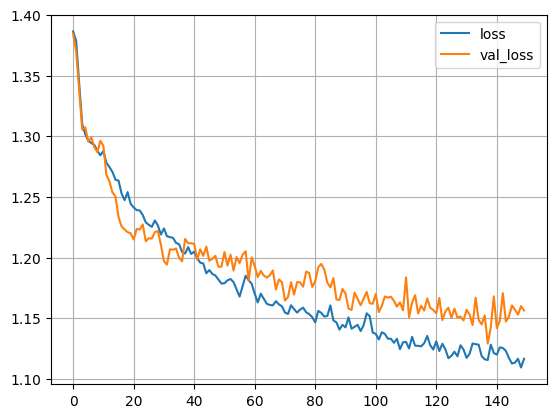

In [53]:
# Графики фнкции потерь  модели
plt.plot(loss_hist, label='loss')
plt.plot(val_loss_hist, label='val_loss')
plt.grid()
plt.legend()